In [ ]:
# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth --assume-yes --fix-missing > /dev/null
print('done!')

# update the version of music21, used to parse midi files
!pip install music21==6.3.0

installing fluidsynth...
Extracting templates from packages: 100%
done!
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for music21: filename=music21-6.3.0-py3-none-any.whl size=21888027 sha256=e2162910dff1b95286f65ed76521ec6f85025d50523fc58b610793cf1fcd22fa
  Stored in directory: /root/.cache/pip/wheels/f6/54/79/c780be458ecfc3bdc7bd0198436cc21e3148348389499d330a
Successfully built music21
  Attempting uninstall: music21
    Found existing installation: music21 9.1.0
    Uninstalling music21-9.1.0:
      Successfully uninstalled music21-9.1.0


In [ ]:
import os, random, math
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from music21 import midi
from IPython.display import Audio

from typing import Optional, Tuple
from torch import Tensor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

Create a dataframe and pytorch dataset that to load the performance data for training. This combines the Maestro dataset with another dataset that contains the preprocessed performance files.

In [ ]:
!mkdir perfevents

In [ ]:
%cd /content/perfevents

/content/perfevents


In [ ]:
!unzip /content/drive/MyDrive/maestro-v2.0.0_withperfevents.zip

Archive:  /content/drive/MyDrive/maestro-v2.0.0_withperfevents.zip
   creating: 2004/
  inflating: 2004/MIDI-Unprocessed_XP_21_R1_2004_02_ORIG_MID--AUDIO_21_R1_2004_03_Track03_wav.midi.pt  
  inflating: 2004/MIDI-Unprocessed_XP_15_R2_2004_01_ORIG_MID--AUDIO_15_R2_2004_02_Track02_wav.midi.pt  
  inflating: 2004/MIDI-Unprocessed_XP_08_R1_2004_04-06_ORIG_MID--AUDIO_08_R1_2004_05_Track05_wav--2.midi.pt  
  inflating: 2004/MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_08_Track08_wav.midi.pt  
  inflating: 2004/MIDI-Unprocessed_XP_19_R2_2004_01_ORIG_MID--AUDIO_19_R2_2004_02_Track02_wav.midi.pt  
  inflating: 2004/MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_02_Track02_wav.midi.pt  
  inflating: 2004/MIDI-Unprocessed_XP_14_R1_2004_04_ORIG_MID--AUDIO_14_R1_2004_06_Track06_wav.midi.pt  
  inflating: 2004/MIDI-Unprocessed_XP_19_R1_2004_01-02_ORIG_MID--AUDIO_19_R1_2004_02_Track02_wav.midi.pt  
  inflating: 2004/MIDI-Unprocessed_SMF_05_R1_2004_02-03_ORIG_MID--AUD

In [ ]:
%cd -

/content


In [ ]:
!mkdir maestro-v2

In [ ]:
%cd /content/maestro-v2

/content/maestro-v2


In [ ]:
!unzip /content/drive/MyDrive/maestro_dataset.zip

Archive:  /content/drive/MyDrive/maestro_dataset.zip
  inflating: 2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi  
  inflating: 2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.mp3  
  inflating: 2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi  
  inflating: 2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.mp3  
  inflating: 2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.midi  
  inflating: 2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.mp3  
  inflating: 2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.midi  
  inflating: 2004/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.mp3  
  inflating: 2004/MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.midi  
  inflati

In [ ]:
%cd -

/content


In [ ]:
def get_df(
    maestro_path = '/content/maestro-v2/',
    perf_path = '/content/perfevents/',
):
    df = pd.read_csv(f'{maestro_path}/maestro-v2.0.0.csv')
    for col in ['canonical_composer', 'canonical_title', 'split', 'year']:
        df[col] = df[col].astype('category')
    df['mp3_path'] = maestro_path + df.audio_filename.str.split('.').str.get(0) + '.mp3'
    df['midi_path'] = maestro_path + df.midi_filename
    df['perf_path'] = perf_path + df.midi_filename + '.pt'
    return df


get_df().head()

canonical_composer                canonical_title       split  year  \
0          Alban Berg                   Sonata Op. 1       train  2018   
1          Alban Berg                   Sonata Op. 1       train  2008   
2          Alban Berg                   Sonata Op. 1       train  2017   
3  Alexander Scriabin  24 Preludes Op. 11, No. 13-24       train  2004   
4  Alexander Scriabin               3 Etudes, Op. 65  validation  2006   

                                       midi_filename  \
0  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...   
1  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...   
2  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...   
3  2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...   
4  2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...   

                                      audio_filename    duration  \
0  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  698.661160   
1  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...  759.518471   
2  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...  464.649433   
3  2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...  872.640588   
4  2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...  397.857508   

                                            mp3_path  \
0  /content/maestro-v2/2018/MIDI-Unprocessed_Cham...   
1  /content/maestro-v2/2008/MIDI-Unprocessed_03_R...   
2  /content/maestro-v2/2017/MIDI-Unprocessed_066_...   
3  /content/maestro-v2/2004/MIDI-Unprocessed_XP_2...   
4  /content/maestro-v2/2006/MIDI-Unprocessed_17_R...   

                                           midi_path  \
0  /content/maestro-v2/2018/MIDI-Unprocessed_Cham...   
1  /content/maestro-v2/2008/MIDI-Unprocessed_03_R...   
2  /content/maestro-v2/2017/MIDI-Unprocessed_066_...   
3  /content/maestro-v2/2004/MIDI-Unprocessed_XP_2...   
4  /content/maestro-v2/2006/MIDI-Unprocessed_17_R...   

                                           perf_path  
0  /content/perfevents/2018/MIDI-Unprocessed_Cham...  
1  /content/perfevents/2008/MIDI-Unprocessed_03_R...  
2  /content/perfevents/2017/MIDI-Unprocessed_066_...  
3  /content/perfevents/2004/MIDI-Unprocessed_XP_2...  
4  /content/perfevents/2006/MIDI-Unprocessed_17_R...

In [ ]:
class DataframeDataset(torch.utils.data.Dataset):
    # df is a dataframe that has a path column (path_col) for each file
    # features is a list of columns in the dataframe that will be added to items
    # preload_device can be cpu/cuda
    def __init__(self, df, features=[], path_col='path', preload_device=None):
        self.df = df.copy()
        for feature in features:
            if self.df[feature].dtype.name == 'category':
                # convert categories to indices
                self.df[feature] = self.df[feature].cat.codes

        self.features = features
        self.path_col = path_col
        self.preloaded_data = None
        if preload_device is not None:
            self.preloaded_features = []
            self.preloaded_data = []
            for i, row in self.df.iterrows():
                self.preloaded_features.append({
                    k: torch.tensor(v).to(preload_device)
                    for k, v in row[features].to_dict().items()
                })
                self.preloaded_data.append(
                    self._get_data(row[self.path_col]).to(preload_device)
                )

    def __len__(self):
        return(len(self.df))

    def __getitem__(self, index):
        if self.preloaded_data is None:
            row = self.df.iloc[index]
            features = row[self.features].to_dict()
            data = self._get_data(row[self.path_col])
        else:
            features = self.preloaded_features[index]
            data = self.preloaded_data[index]
        return {**features, 'data': data}

    def _get_data(self, path):
        raise NotImplementedError()


class PerformanceDataset(DataframeDataset):
    def __init__(self, df, features=[], path_col='perf_path', preload_device=None, transform=None):
        self.transform = transform
        super().__init__(df, features, path_col, preload_device)

    def _get_data(self, path):
        return torch.jit.load(path).state_dict()['0'].long()

    def __getitem__(self, index):
        item = super().__getitem__(index)
        if self.transform is not None:
            item['data'] = self.transform(item['data'])
        return item

## Data augmentation

We can expand the dataset by adding some augmentations, including random cropping, increasing/decreasing pitch, and tweaking time delays.

In [ ]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, x):
        for transform in self.transforms:
            x = transform(x)
        return x


class RandomCrop1D:
    def __init__(self, size, pad_if_needed=True, fill=0):
        self.size = size
        self.pad_if_needed = pad_if_needed
        self.fill = fill
    def __call__(self, x):
        x_len = x.shape[-1]
        len_diff = x_len - self.size
        pad_needed = len_diff < 0
        if pad_needed and not self.pad_if_needed:
            raise Exception('too small')
        start = random.randint(0, max(0, len_diff))
        crop = x[..., start:start+self.size]
        if pad_needed:
            return F.pad(crop, pad=(0, max(0, -len_diff)), value=self.fill)
        return crop


class AugmentPitch:
    def __init__(self, half_steps=3, in_place=True):
        self.half_steps = half_steps
        self.in_place = in_place

    def __call__(self, x):
        if not self.in_place:
            x = x.clone()
        pitch_transposition = random.randint(-self.half_steps, self.half_steps)
        note_ons = (x >= 0) * (x < 128)
        x[note_ons] = torch.clamp(x[note_ons] + pitch_transposition, 0, 127)
        note_offs = (x >= 128) * (x < 256)
        x[note_offs] = torch.clamp(x[note_offs] + pitch_transposition, 128, 255)
        return x


class AugmentTime:
    def __init__(self, time_pct=2.5, num_steps=5, in_place=True):
        self.time_pct = time_pct / 100
        self.in_place = in_place
        self.num_steps = num_steps

    def __call__(self, x):
        if not self.in_place:
            x = x.clone()
        time_stretch = (1 - self.time_pct * 2) + random.randint(0, self.num_steps - 1) * self.time_pct
        time_shifts = (x >= 256) * (x < 356)
        x[time_shifts] = torch.clamp((x[time_shifts] - 256) * time_stretch, 0, 99).long() + 256
        return x

In [ ]:
df = get_df()

train_dataset = PerformanceDataset(
    df[df.split == 'train'],
    transform=Compose([
        RandomCrop1D(2048, fill=388),
        AugmentPitch(in_place=False),
        AugmentTime(),
    ]),
    preload_device='cuda',
)

val_dataset = PerformanceDataset(
    df[df.split == 'validation'],
    transform=Compose([
        RandomCrop1D(2048, fill=388),
    ]),
    preload_device='cuda',
)

## Convert data into MIDI and WAV files

Visualize and listen to performance tensors by converting them in MIDI/WAV. This code will be used to convert the output of a model that is trained to output the perforamnce representation into audible music.

In [ ]:
def read_midi(filepath):
  mf = midi.MidiFile()
  mf.open(filepath)
  mf.read()
  mf.close()
  return mf


def write_midi(mf, filename = 'tempmidi.mid'):
  mf.open(filename, attrib='wb')
  mf.write()
  mf.close()
  return filename


def midi_to_wav(filename):
  # linux ships with a default midi font
  !fluidsynth -F $filename\.wav -r 16000 -i -n -T wav /usr/share/sounds/sf2/FluidR3_GM.sf2 $filename > /dev/null
  return filename + '.wav'


def play_midi(mf, secs):
  data, rate = torchaudio.load(midi_to_wav(write_midi(mf)))
  display(Audio(data[0, :16000 * secs], rate=rate))


class MidiToPerformanceConverter:
    def __init__(self):
        self.event_to_idx = {}
        for i in range(128):
          self.event_to_idx['note-on-' + str(i)] = i
        for i in range(128):
          self.event_to_idx['note-off-' + str(i)] = i + 128
        for i in range(100):
          self.event_to_idx['time-shift-' + str(i + 1)] = i + 128 + 128
        for i in range(32):
          self.event_to_idx['velocity-' + str(i)] = i + 128 + 128 + 100
        self.idx_to_event = list(self.event_to_idx.keys())
        self.num_channels = len(self.idx_to_event)


    def midi_to_idxs(self, mf):
      event_to_idx = self.event_to_idx
      ticks_per_beat = mf.ticksPerQuarterNote
      # The maestro dataset uses the first track to store tempo data
      tempo_data = next(e for e in mf.tracks[0].events if e.type == midi.MetaEvents.SET_TEMPO).data
      # tempo data is stored at microseconds per beat (beat = quarter note)
      microsecs_per_beat = int.from_bytes(tempo_data, 'big')
      millis_per_tick = microsecs_per_beat / ticks_per_beat / 1e3

      idxs = []
      started = False
      previous_t = None
      is_pedal_down = False
      notes_to_turn_off = set()
      notes_on = set()

      # The second track stores the actual performance
      for e in mf.tracks[1].events:
        #if started and e.type == 'DeltaTime' and e.time > 0:
        if e.type == 'DeltaTime' and e.time > 0:
          # event times are stored as ticks, so convert to milliseconds
          millis = e.time * millis_per_tick

          # combine repeated delta time events
          t = millis + (0 if previous_t is None else previous_t)

          # we can only represent a max time of 1 second (1000 ms)
          # so we must split up times that are larger than that into separate events
          while t > 0:
            t_chunk = min(t, 1000)
            idx = event_to_idx['time-shift-' + str(math.ceil(t_chunk / 10))]
            if previous_t is None:
              idxs.append(idx)
            else:
              idxs[-1] = idx
              previous_t = None
            t -= t_chunk
          previous_t = t_chunk

        elif e.type == midi.ChannelVoiceMessages.NOTE_ON:
          if e.velocity == 0:
            if is_pedal_down:
              notes_to_turn_off.add(e.pitch)
            elif e.pitch in notes_on:
              idxs.append(event_to_idx['note-off-' + str(e.pitch)])
              notes_on.remove(e.pitch)
              previous_t = None
          else:
            if e.pitch in notes_to_turn_off:
              idxs.append(event_to_idx['note-off-' + str(e.pitch)])
              notes_to_turn_off.remove(e.pitch)
              notes_on.remove(e.pitch)

            # midi supports 128 velocities, but our representation only allows 32
            idxs.append(event_to_idx['velocity-' + str(e.velocity // 4)])
            idxs.append(event_to_idx['note-on-' + str(e.pitch)])
            notes_on.add(e.pitch)
            started = True
            previous_t = None

        elif e.type == midi.ChannelVoiceMessages.CONTROLLER_CHANGE and e.parameter1 == 64: # sustain pedal
          # pedal values greater than 64 mean the pedal is being held down,
          # otherwise it's up
          if is_pedal_down and e.parameter2 < 64:
            is_pedal_down = False
            for pitch in notes_to_turn_off:
              idxs.append(event_to_idx['note-off-' + str(pitch)])
              notes_on.remove(pitch)
            notes_to_turn_off = set()
            previous_t = None
          elif not is_pedal_down and e.parameter2 >= 64:
            is_pedal_down = True
            previous_t = None

      return idxs


    def make_note(self, track, pitch, velocity):
      e = midi.MidiEvent(track, type=midi.ChannelVoiceMessages.NOTE_ON, channel=1)
      e.pitch = int(pitch)
      e.velocity = int(velocity)
      return e


    def idxs_to_midi(self, idxs, verbose=False):
      if type(idxs) == torch.Tensor:
        idxs = idxs.detach().numpy()

      mf = midi.MidiFile()
      mf.ticksPerQuarterNote = 1024

      # The maestro dataset uses the first track to store tempo data, and the second
      # track to store the actual performance. So follow that convention.
      tempo_track = midi.MidiTrack(0)
      track = midi.MidiTrack(1)
      mf.tracks = [tempo_track, track]

      tempo = midi.MidiEvent(tempo_track, type=midi.MetaEvents.SET_TEMPO)
      # temp.data is the number of microseconds per beat (per quarter note)
      # So to set ticks per millis = 1 (easy translation from time-shift values to ticks),
      # tempo.data must be 1e3 * 1024, since ticksPerQuarterNote is 1024 (see above)
      tempo.data = int(1e3 * 1024).to_bytes(3, 'big')

      end_of_track = midi.MidiEvent(tempo_track, type=midi.MetaEvents.END_OF_TRACK)
      end_of_track.data = ''
      tempo_track.events = [
        # there must always be a delta time before each event
        midi.DeltaTime(tempo_track, time=0),
        tempo,
        midi.DeltaTime(tempo_track, time=0),
        end_of_track
      ]

      track.events = [midi.DeltaTime(track, time=0)]

      # set to 0 initially in case no velocity events occur before the first note
      current_velocity = 0
      notes_on = set()
      errors = {'is_on': 0, 'is_not_on': 0}

      for idx in idxs:
        if 0 <= idx < 128: # note-on
          pitch = idx
          if pitch in notes_on:
            if verbose:
              print(pitch, 'is already on')
            errors['is_on'] += 1
            continue
          if track.events[-1].type != 'DeltaTime':
            track.events.append(midi.DeltaTime(track, time=0))
          track.events.append(self.make_note(track, pitch, current_velocity))
          notes_on.add(pitch)

        elif 128 <= idx < 256: # note-off
          pitch = idx - 128
          if pitch not in notes_on:
            if verbose:
              print(pitch, 'is not on')
            errors['is_not_on'] += 1
            continue
          if track.events[-1].type != 'DeltaTime':
            track.events.append(midi.DeltaTime(track, time=0))
          track.events.append(self.make_note(track, pitch, 1))
          notes_on.remove(pitch)

        elif 256 <= idx < 356: # time-shift
          t = (1 + idx - 256) * 10
          if track.events[-1].type == 'DeltaTime':
            # combine repeated delta times
            track.events[-1].time += t
          else:
            track.events.append(midi.DeltaTime(track, time=t))

        else: # velocity
          current_velocity = (idx - 356) * 4

      if verbose:
        print('remaining notes left on:', notes_on)

      if track.events[-1].type != 'DeltaTime':
        track.events.append(midi.DeltaTime(track, time=0))
      track.events.append(end_of_track)

      return mf, errors

In [ ]:
def display_audio(title, audio):
    plt.title(title)
    plt.imshow(torch.log10(T.MelSpectrogram(n_mels=80)(audio) + 1e-6)[0])
    plt.show()
    display(Audio(audio, rate=16000))

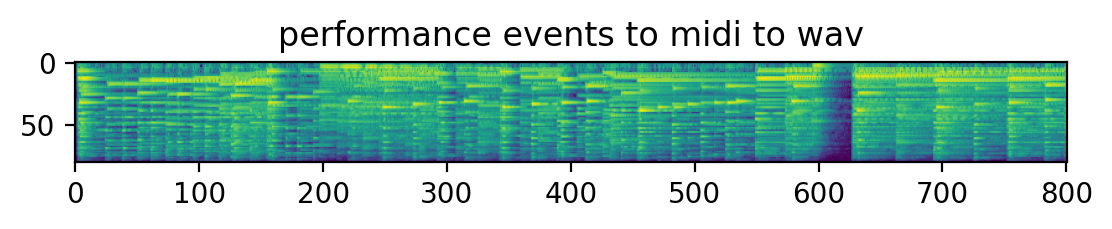

In [ ]:
idxs = train_dataset[0]['data'].to('cpu')

converter = MidiToPerformanceConverter()
mf = converter.idxs_to_midi(idxs)[0]
midi_filename = write_midi(mf)
wav_filename = midi_to_wav(midi_filename)
midi_to_wav_audio = torchaudio.load(wav_filename)
midi_to_wav_audio = midi_to_wav_audio[0][:1, :16000*10]

display_audio('performance events to midi to wav', midi_to_wav_audio)

# Model

Create the PerformanceRNN model, which embedds performance events into an internal embedding, learns sequences autoregressively, and then projects its internal representation back to a distribution over possible events.

The model has a forward method to predict the next event given a sequence, as well as a forward_seq method that efficiently predicts N subsequent elements into the future by feeding its own predicted back into itself in a loop.

In [ ]:


##ORIGINAL
class PerformanceRNN(nn.Module):
    def __init__(self, num_embedding, hidden_dim=128, num_layers=3):
        super(PerformanceRNN, self).__init__()
        self.input_embedding = nn.Embedding(num_embeddings=num_embedding, embedding_dim=hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.output_linear = nn.Linear(in_features=hidden_dim, out_features=num_embedding)
        self.hidden_dim=hidden_dim


    def forward(
        self,
        x: torch.Tensor,
        state: Optional[Tuple[torch.Tensor, torch.Tensor]]=None,
    ) -> Tuple[Tensor, Tuple[Tensor, Tensor]]:
        x = self.input_embedding(x)
        x, state = self.lstm(x, state) # (batch, seq, hidden)
        x = self.output_linear(x)
        return x, state





    # prime is (batch, prime_seq)
    # returns (batch, prime_seq + steps)
    def forward_seq(self, prime, steps, greedy):
        if greedy:
            sample = lambda x: torch.argmax(x, axis=2)
        else:
            sample = lambda x: torch.distributions.Categorical(torch.softmax(x, axis=2)).sample()

        x, state = self.forward(prime)
        output = sample(x)
        for _ in range(steps - 1):
            x, state = self.forward(output[:, -1:], state)
            x = sample(x)
            output = torch.cat([output, x], axis=1)

        return torch.cat([prime, output], axis=1)

**Attention with uni directional LSTM**

In [ ]:
class PerformanceRNN_attn1(nn.Module):
    def __init__(self, num_embedding, hidden_dim=128, num_layers=3):
        super(PerformanceRNN_attn1, self).__init__()
        self.input_embedding = nn.Embedding(num_embeddings=num_embedding, embedding_dim=hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=False)

        self.output_linear = nn.Linear(in_features=hidden_dim, out_features=num_embedding)

        self.hidden_dim=hidden_dim


    def forward(self, x, state=None):
        x = self.input_embedding(x)
        x, state = self.lstm(x, state)
        x = self.apply_attention(x)
        x = self.output_linear(x)
        return x, state


    def apply_attention(self, lstm_output):
      batch_size, seq_len, hidden_dim = lstm_output.shape
      keys = lstm_output.transpose(1, 2)  # Shape: (batch, 2*hidden_dim, seq_len)
      queries = lstm_output

      # Calculate energy scores
      energy = torch.bmm(queries, keys) / (self.hidden_dim ** 0.5)  # Shape: (batch, seq_len, seq_len)
      attention_weights = F.softmax(energy, dim=2)  # Apply softmax over seq_len

      # Apply attention weights
      attended_output = torch.bmm(attention_weights, lstm_output)
      return attended_output

    def forward_seq(self, prime, steps, greedy):
        if greedy:
            sample = lambda x: torch.argmax(x, axis=2)
        else:
            sample = lambda x: torch.distributions.Categorical(torch.softmax(x, axis=2)).sample()

        x, state = self.forward(prime)
        output = sample(x)
        for _ in range(steps - 1):
            x, state = self.forward(output[:, -1:], state)
            x = sample(x)
            output = torch.cat([output, x], axis=1)

        return torch.cat([prime, output], axis=1)

##modifying the original unidirectional lstm based architecture to a bidirectional lstm with attention architecture

![image](https://www.researchgate.net/publication/342964787/figure/fig2/AS:913823821201411@1594883985179/Connections-depicting-the-structure-of-the-BiLSTM-model-with-the-attention-mechanism-at-a.png)

In [ ]:
class PerformanceRNN_attn(nn.Module):
    def __init__(self, num_embedding, hidden_dim=128, num_layers=3):
        super(PerformanceRNN_attn, self).__init__()
        self.input_embedding = nn.Embedding(num_embeddings=num_embedding, embedding_dim=hidden_dim)
        self.lstm = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

        self.output_linear = nn.Linear(in_features=2*hidden_dim, out_features=num_embedding)

        self.hidden_dim=hidden_dim


    def forward(self, x, state=None):
        x = self.input_embedding(x)
        x, state = self.lstm(x, state)
        x = self.apply_attention(x)
        x = self.output_linear(x)
        return x, state


    def apply_attention(self, lstm_output):
      batch_size, seq_len, hidden_dim = lstm_output.shape
      keys = lstm_output.transpose(1, 2)  # Shape: (batch, 2*hidden_dim, seq_len)
      queries = lstm_output

      # Calculate energy scores
      energy = torch.bmm(queries, keys) / (self.hidden_dim ** 0.5)  # Shape: (batch, seq_len, seq_len)
      attention_weights = F.softmax(energy, dim=2)  # Apply softmax over seq_len

      # Apply attention weights
      attended_output = torch.bmm(attention_weights, lstm_output)
      return attended_output

    def forward_seq(self, prime, steps, greedy):
        if greedy:
            sample = lambda x: torch.argmax(x, axis=2)
        else:
            sample = lambda x: torch.distributions.Categorical(torch.softmax(x, axis=2)).sample()

        x, state = self.forward(prime)
        output = sample(x)
        for _ in range(steps - 1):
            x, state = self.forward(output[:, -1:], state)
            x = sample(x)
            output = torch.cat([output, x], axis=1)

        return torch.cat([prime, output], axis=1)

In [ ]:
def prepare_batch(batch):
    data = batch['data']
    return data[..., :-1], data[..., 1:]


cel = torch.nn.CrossEntropyLoss()
def lossfn(prediction, y):
    return cel(prediction.transpose(1, 2), y)

In [ ]:

DEVICE = 'cuda'

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)
model_0 = PerformanceRNN(converter.num_channels + 1, hidden_dim=512).to(DEVICE)

x, y = prepare_batch(next(iter(train_dataloader)))
x = x.to(DEVICE)
y = y.to(DEVICE)
prediction = model_0(x)[0]
print(prediction.shape)


loss = lossfn(prediction, y)

y_seq = model_0.forward_seq(x[:, :1], 10, greedy=False)
y_seq_greedy = model_0.forward_seq(x[:, :1], 10, greedy=True)
x.shape, y.shape, prediction.shape, loss.shape, y_seq.shape, y_seq_greedy.shape


torch.Size([16, 2047, 389])


(torch.Size([16, 2047]),
 torch.Size([16, 2047]),
 torch.Size([16, 2047, 389]),
 torch.Size([]),
 torch.Size([16, 11]),
 torch.Size([16, 11]))

In [ ]:

DEVICE = 'cuda'

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16)
model = PerformanceRNN_attn(converter.num_channels + 1, hidden_dim=512).to(DEVICE)

x, y = prepare_batch(next(iter(train_dataloader)))
x = x.to(DEVICE)
y = y.to(DEVICE)
prediction = model(x)[0]
print(prediction.shape)


loss = lossfn(prediction, y)

y_seq = model.forward_seq(x[:, :1], 10, greedy=False)
y_seq_greedy = model.forward_seq(x[:, :1], 10, greedy=True)
x.shape, y.shape, prediction.shape, loss.shape, y_seq.shape, y_seq_greedy.shape


torch.Size([16, 2047, 389])


(torch.Size([16, 2047]),
 torch.Size([16, 2047]),
 torch.Size([16, 2047, 389]),
 torch.Size([]),
 torch.Size([16, 11]),
 torch.Size([16, 11]))

# Train

Train the model using the performance data loaded above, recording train/validation performance.

In [ ]:
def train(
    model,
    optimizer,
    lossfn,
    train_dataloader,
    val_dataloader,
    train_cb,
    val_cb,
    prepare_batch,
    num_epochs,
):
    for epoch in range(num_epochs):
        print(f'## EPOCH {epoch} - train - {len(train_dataloader)} batches ##')
        model.train()
        for i, batch in enumerate(train_dataloader):
            x, y = prepare_batch(batch)
            prediction = model(x)[0]
            loss = lossfn(prediction, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_cb(i, prediction, y, loss)

        print(f'## EPOCH {epoch} - validation - {len(val_dataloader)} batches ##')
        model.eval()
        with torch.no_grad():
            for i, batch in enumerate(val_dataloader):
                x, y = prepare_batch(batch)
                prediction = model(x)[0]
                loss = lossfn(prediction, y)
                val_cb(i, prediction, y, loss)

In [ ]:
def make_cb(dataloader):
    losses = []
    acc = []
    num_batches = len(dataloader)
    def cb(i, prediction, y, loss):
        losses.append(loss)
        acc.append((torch.argmax(prediction, -1) == y).float().mean())
        #print(i, end=' ' if i < num_batches - 1 else '\n')
    return losses, acc, cb


# linearly interpolate b to match a's length, for displaying val/train loss
def interpolate(a, b):
    return F.interpolate(
        torch.tensor(b)[None, None],
        len(a),
        mode='linear',
        align_corners=True,
    )[0, 0]

In [ ]:
model = PerformanceRNN_attn(converter.num_channels + 1, hidden_dim=512).to('cuda')
optimizer = torch.optim.Adam(model.parameters())

train_losses, train_acc, train_cb = make_cb(train_dataloader)
val_losses, val_acc, val_cb = make_cb(val_dataloader)

In [ ]:
train(
    model,
    optimizer,
    lossfn,
    train_dataloader,
    val_dataloader,
    train_cb,
    val_cb,
    prepare_batch,
    num_epochs=10,
)

## EPOCH 0 - train - 61 batches ##
## EPOCH 0 - validation - 9 batches ##
## EPOCH 1 - train - 61 batches ##
## EPOCH 1 - validation - 9 batches ##
## EPOCH 2 - train - 61 batches ##
## EPOCH 2 - validation - 9 batches ##
## EPOCH 3 - train - 61 batches ##
## EPOCH 3 - validation - 9 batches ##
## EPOCH 4 - train - 61 batches ##
## EPOCH 4 - validation - 9 batches ##
## EPOCH 5 - train - 61 batches ##
## EPOCH 5 - validation - 9 batches ##
## EPOCH 6 - train - 61 batches ##
## EPOCH 6 - validation - 9 batches ##
## EPOCH 7 - train - 61 batches ##
## EPOCH 7 - validation - 9 batches ##
## EPOCH 8 - train - 61 batches ##
## EPOCH 8 - validation - 9 batches ##
## EPOCH 9 - train - 61 batches ##
## EPOCH 9 - validation - 9 batches ##


##LOSS FOR OUR MODEL WITH ATTENTION

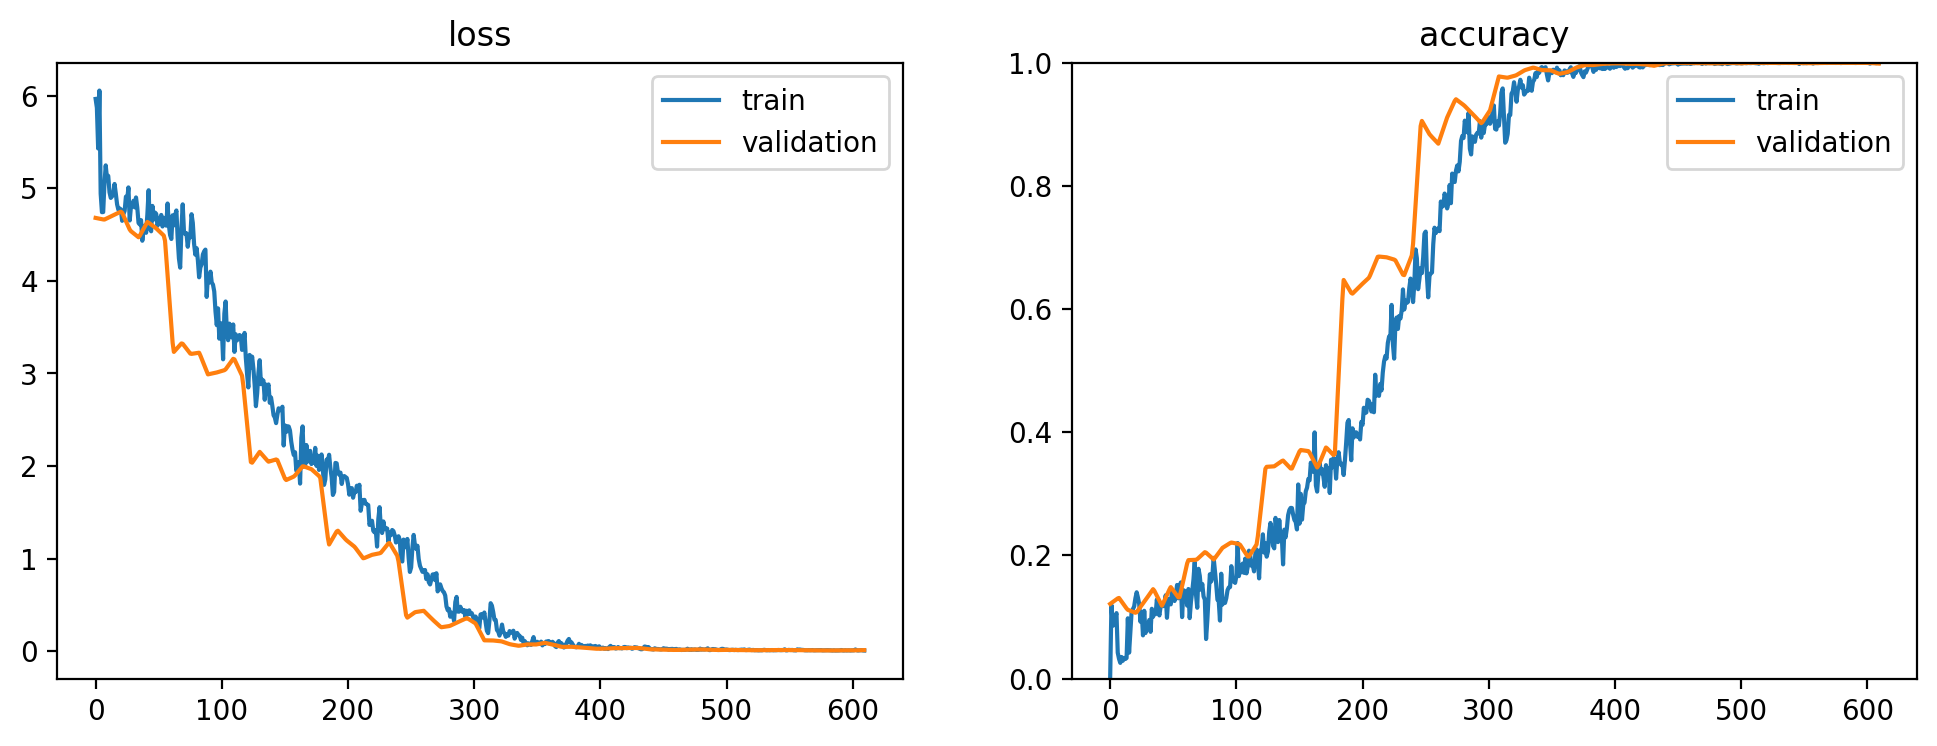

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('loss')
data = [t.cpu() for t in train_losses]
data2=[t.detach() for t in data]
plt.plot(data2, label='train')
plt.plot(interpolate(train_losses, val_losses), label='validation')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.ylim(0, 1)
data = [t.cpu() for t in train_acc]
data2=[t.detach() for t in data]
plt.plot(data2, label='train')
plt.plot(interpolate(train_acc, val_acc), label='validation')
plt.legend()
plt.show()

In [ ]:
model_0 = PerformanceRNN(converter.num_channels + 1, hidden_dim=512).to('cuda')
optimizer = torch.optim.Adam(model_0.parameters())

train_losses0, train_acc0, train_cb0 = make_cb(train_dataloader)
val_losses0, val_acc0, val_cb0 = make_cb(val_dataloader)
train(
    model_0,
    optimizer,
    lossfn,
    train_dataloader,
    val_dataloader,
    train_cb0,
    val_cb0,
    prepare_batch,
    num_epochs=10,
)

## EPOCH 0 - train - 61 batches ##
## EPOCH 0 - validation - 9 batches ##
## EPOCH 1 - train - 61 batches ##
## EPOCH 1 - validation - 9 batches ##
## EPOCH 2 - train - 61 batches ##
## EPOCH 2 - validation - 9 batches ##
## EPOCH 3 - train - 61 batches ##
## EPOCH 3 - validation - 9 batches ##
## EPOCH 4 - train - 61 batches ##
## EPOCH 4 - validation - 9 batches ##
## EPOCH 5 - train - 61 batches ##
## EPOCH 5 - validation - 9 batches ##
## EPOCH 6 - train - 61 batches ##
## EPOCH 6 - validation - 9 batches ##
## EPOCH 7 - train - 61 batches ##
## EPOCH 7 - validation - 9 batches ##
## EPOCH 8 - train - 61 batches ##
## EPOCH 8 - validation - 9 batches ##
## EPOCH 9 - train - 61 batches ##
## EPOCH 9 - validation - 9 batches ##


##LOSS FOR THE ORIGINAL PERFORMANCE RNN

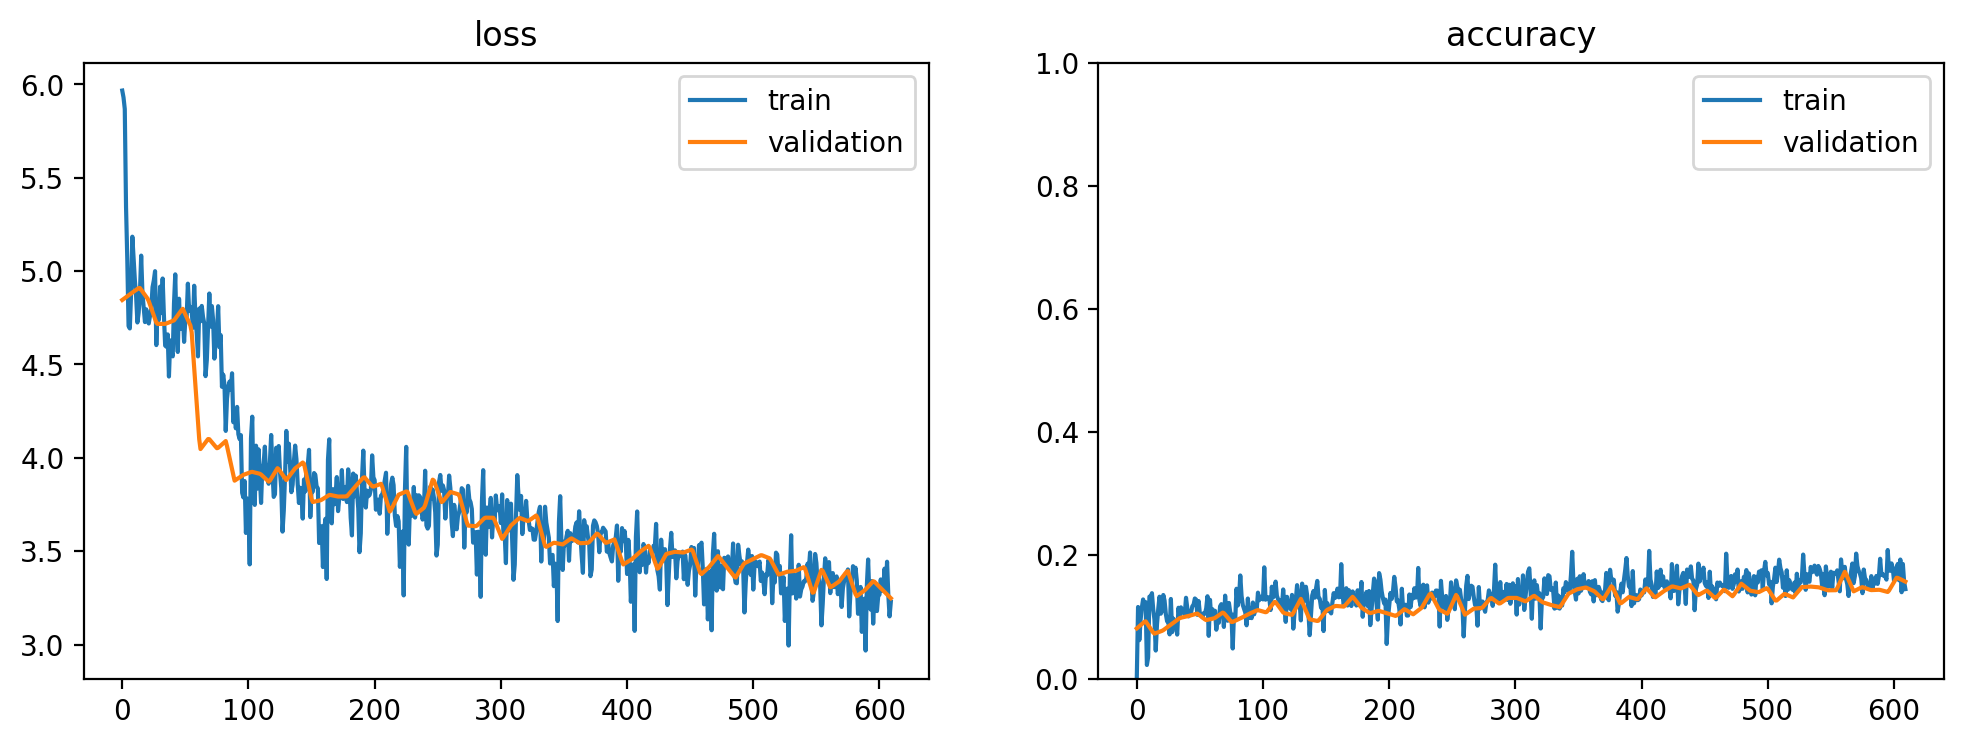

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('loss')
data = [t.cpu() for t in train_losses0]
data2=[t.detach() for t in data]
plt.plot(data2, label='train')
plt.plot(interpolate(train_losses0, val_losses0), label='validation')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.ylim(0, 1)
data = [t.cpu() for t in train_acc0]
data2=[t.detach() for t in data]
plt.plot(data2, label='train')
plt.plot(interpolate(train_acc0, val_acc0), label='validation')
plt.legend()
plt.show()

###The validation loss seems to have improved!

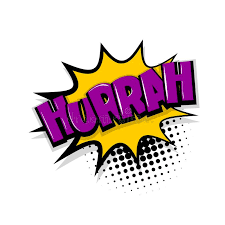

In [ ]:
model_1 = PerformanceRNN_attn1(converter.num_channels + 1, hidden_dim=512).to('cuda')
optimizer = torch.optim.Adam(model_0.parameters())

train_losses1, train_acc1, train_cb1 = make_cb(train_dataloader)
val_losses1, val_acc1, val_cb1 = make_cb(val_dataloader)
train(
    model_1,
    optimizer,
    lossfn,
    train_dataloader,
    val_dataloader,
    train_cb1,
    val_cb1,
    prepare_batch,
    num_epochs=100,
)

## EPOCH 0 - train - 61 batches ##
## EPOCH 0 - validation - 9 batches ##
## EPOCH 1 - train - 61 batches ##
## EPOCH 1 - validation - 9 batches ##
## EPOCH 2 - train - 61 batches ##
## EPOCH 2 - validation - 9 batches ##
## EPOCH 3 - train - 61 batches ##
## EPOCH 3 - validation - 9 batches ##
## EPOCH 4 - train - 61 batches ##
## EPOCH 4 - validation - 9 batches ##
## EPOCH 5 - train - 61 batches ##
## EPOCH 5 - validation - 9 batches ##
## EPOCH 6 - train - 61 batches ##
## EPOCH 6 - validation - 9 batches ##
## EPOCH 7 - train - 61 batches ##
## EPOCH 7 - validation - 9 batches ##
## EPOCH 8 - train - 61 batches ##
## EPOCH 8 - validation - 9 batches ##
## EPOCH 9 - train - 61 batches ##
## EPOCH 9 - validation - 9 batches ##
## EPOCH 10 - train - 61 batches ##
## EPOCH 10 - validation - 9 batches ##
## EPOCH 11 - train - 61 batches ##
## EPOCH 11 - validation - 9 batches ##
## EPOCH 12 - train - 61 batches ##
## EPOCH 12 - validation - 9 batches ##
## EPOCH 13 - train - 61 batches

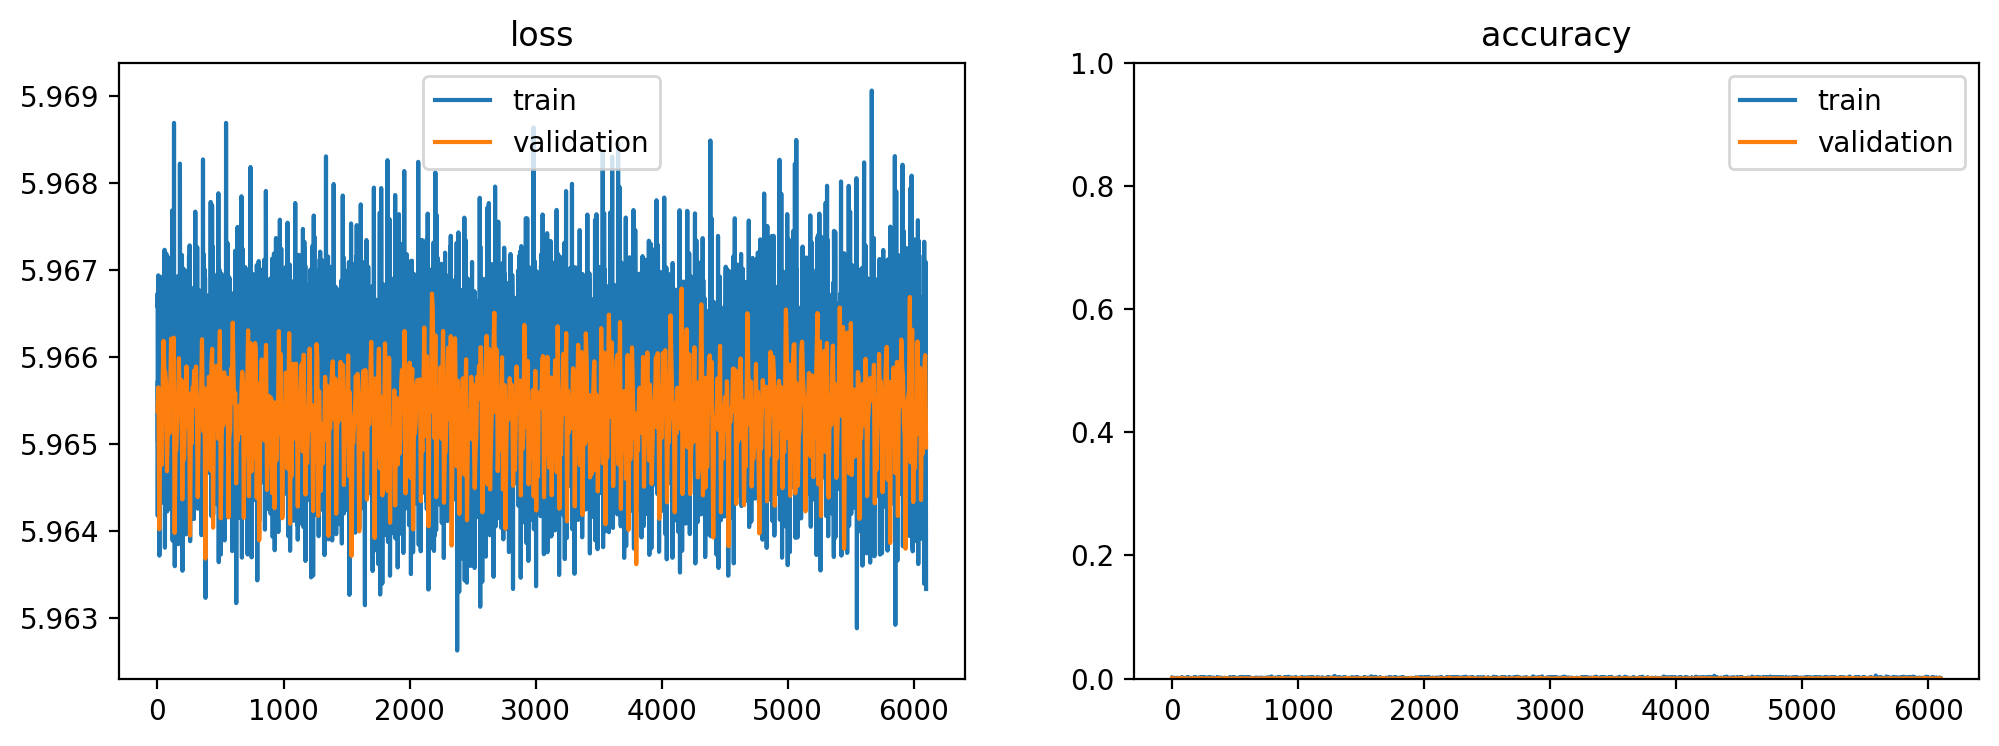

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('loss')
data = [t.cpu() for t in train_losses1]
data2=[t.detach() for t in data]
plt.plot(data2, label='train')
plt.plot(interpolate(train_losses1, val_losses1), label='validation')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('accuracy')
plt.ylim(0, 1)
data = [t.cpu() for t in train_acc1]
data2=[t.detach() for t in data]
plt.plot(data2, label='train')
plt.plot(interpolate(train_acc1, val_acc1), label='validation')
plt.legend()
plt.show()

# Inference

Now that we've trained a model, use it to generate music! One way to do this is to pass some events from an existing piece into the model and ask it to predict subsequent events. We can then compare the ground truth to the generated version.

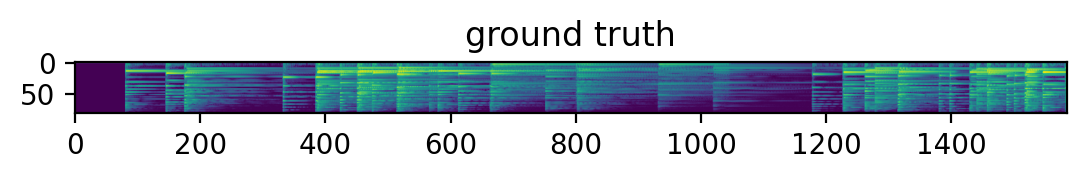

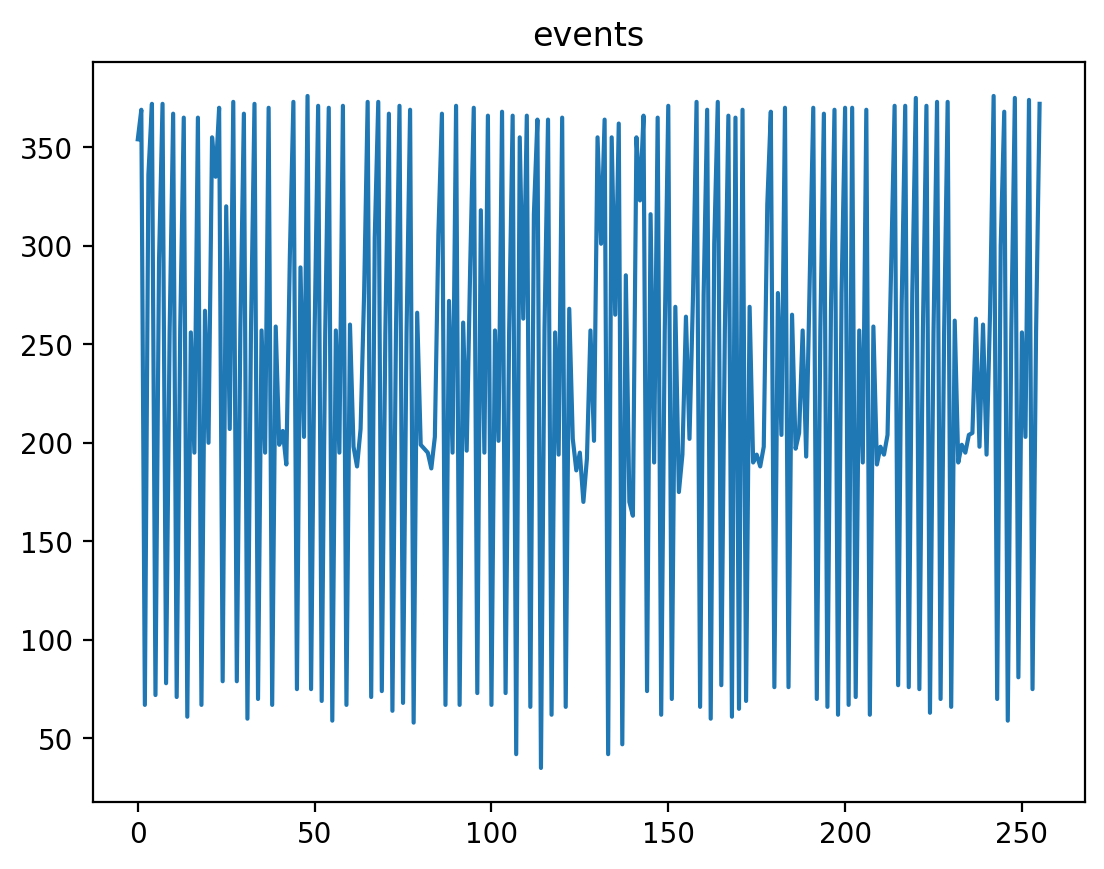

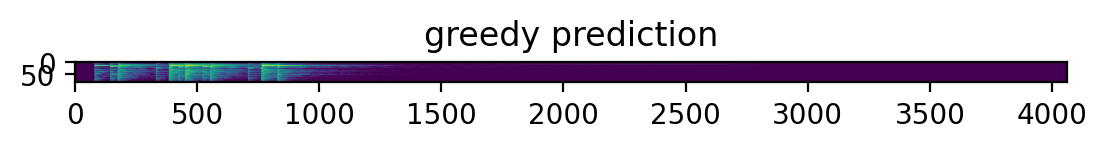

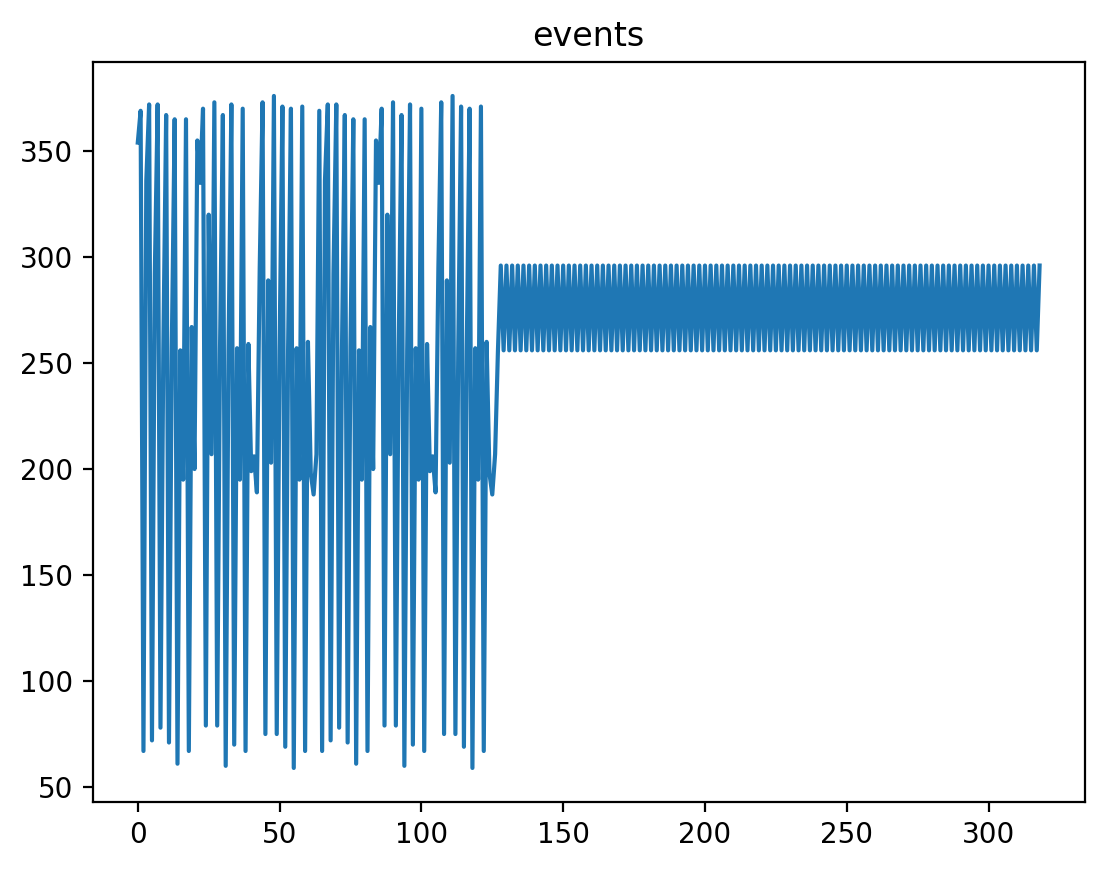

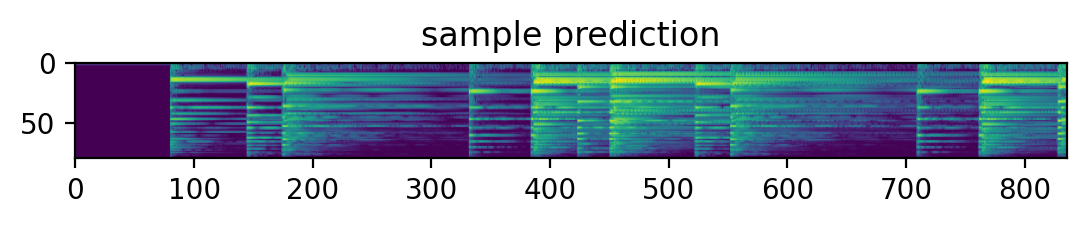

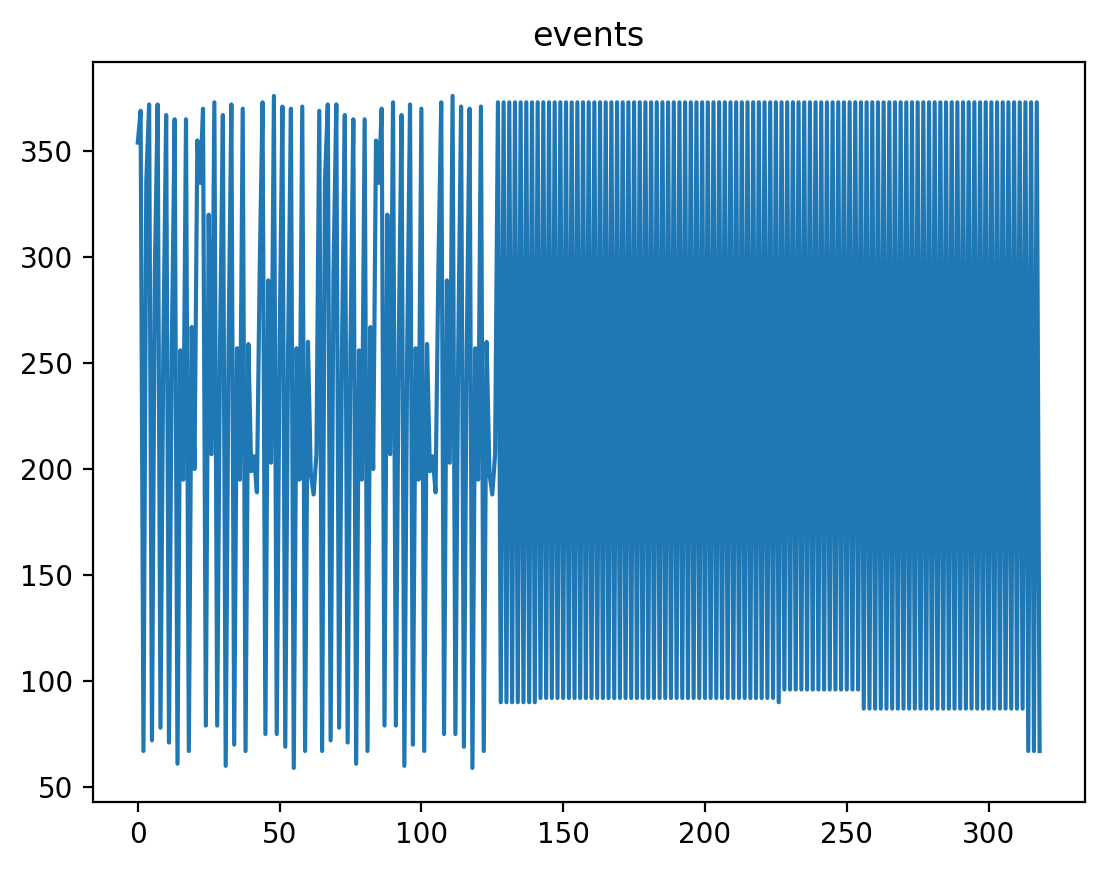

In [ ]:
def convert_and_display(title, idxs):
    mf = converter.idxs_to_midi(idxs.to('cpu'))[0]
    midi_filename = write_midi(mf)
    wav_filename = midi_to_wav(midi_filename)
    midi_to_wav_audio = torchaudio.load(wav_filename)
    midi_to_wav_audio = midi_to_wav_audio[0][:1]
    display_audio(title, midi_to_wav_audio)
    plt.title('events')
    plt.plot(idxs.squeeze().to('cpu'))
    plt.show()


# first 256 events is the first ~20 secs
idxs = train_dataset.preloaded_data[0][:256]

# ground truth
convert_and_display('ground truth', idxs)

# greedy prediction
prime = idxs[:64] # first 64 events is the first ~5 secs
prime = prime[None] # add batch
prediction = model.forward_seq(prime, steps=256 - 64, greedy=True)
convert_and_display('greedy prediction', prediction[0])

# sampling prediction
prediction = model.forward_seq(prime, steps=256 - 64, greedy=False)
convert_and_display('sample prediction', prediction[0])

# Export model

In [ ]:
model.eval()
model.to('cpu')
torch.jit.script(model).save('performance_rnn.pt')
model_loaded = torch.jit.load('performance_rnn.pt')
model_loaded(torch.zeros(1, 1).long())[0].shape